In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [3]:
# with open('test_ind.pickle', 'rb') as handle:
#     test_ind = pickle.load(handle)

# with open('train_ind.pickle', 'rb') as handle:
#     train_ind = pickle.load(handle)

with open('big_test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('big_train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
# train_ind = train_ind[train_ind>=110]
# test_ind = test_ind[test_ind>=110]    
train_ind = list(map(float,train_ind))
test_ind = list(map(float,test_ind))
train_ind, test_ind = train_test_split(train_ind+test_ind,test_size=0.1, random_state=42)
print(len(train_ind),len(test_ind))    


273 31


In [4]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0

for i in sorted(glob('ANO-RCC-VDZP')):
    print(i)
    for j in glob(os.path.join(i,'ozone_*')):
        for k in train_ind:
            if f"{k:.2f}" in j:
                traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                traindf = traindf[traindf['Pair_Energies'].abs()>=1e-5]
                train.append(traindf)
                recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                traincnt+=1
                
        for l in test_ind:
            if f"{l:.2f}" in j:
                testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                testdf = testdf[testdf['Pair_Energies'].abs()>=1e-5]
                test.append(testdf)                    
                recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                testcnt+=1

ANO-RCC-VDZP


In [5]:
# rename = {'h$_{qq}^{0}$':'h$_{q}$',
# '$(F_{q})_{0}$':'$F_{q}$',
# '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
# '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
# '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
# '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
# 'h$_{ss}^{0}$':'h$_{s}$',
# '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
# '$(F_{s})_{0}$':'$F_{s}$',
# '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
# '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
# '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
# 'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
# 'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
# 'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
# 'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
# 'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
# 'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
# 'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
# 'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
# 'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
# 'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
# 'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
# 'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
# 'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
# 'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
# 'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
# 'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
# 'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
# 'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
# 'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
# 'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
# 'typ_0':'type_0',
# 'typ_1':'type_1',
# 'typ_2':'type_2',
# 'typ_3':'type_3',
# '1':"$\mathbf{b}$"         
# }


rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
'typ_0':'$type_0$',
'typ_1':'$type_1$',
'typ_2':'$type_2$',
'typ_3':'$type_3$',
'1':"$\mathbf{b}$"}

In [6]:
dffeat = pd.read_excel('ozone_VDZP_SHAP.xlsx',index_col=0).sort_values(by='shap',ascending=False)

In [7]:
dffeat

,feat,shap
12,h$_{q}$,2.524482e-03
34,$F_{q}$,1.594092e-03
60,$(F_{p}^{\text{SCF}})_{3}$,4.987177e-04
43,$\eta_{s}$,4.581478e-04
19,(h$_{rs}$)$_{1}$,4.564782e-04
...,...,...
61,$(\omega_{p})_{3}$,7.937365e-09
49,$(\omega_{r})_{1}$,6.713771e-09
27,$\mathbf{b}$,5.757099e-09
57,$(\omega_{r})_{2}$,4.405162e-09


In [8]:
maes = {}
r2s = {}
for featlen in np.arange(17,dffeat.shape[0]+17,17):
    feat_shap = dffeat['feat'].iloc[0:featlen].values
    
    print(len(feat_shap)/len(dffeat))
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    
    X_train = train_df[feat_shap].values
    X_test = test_df[feat_shap].values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    kwargs = dict(pd.read_excel("ozone_VDZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)    

    
    traincorrcalc, traincorrpred = traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$']
    testcorrcalc, testcorrpred = testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$']
    print(f"R2: {r2_score(traincorrcalc, traincorrpred):.4f},{r2_score(testcorrcalc, testcorrpred):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(traincorrcalc, traincorrpred)*1e3:.4f},{root_mean_squared_error(testcorrcalc, testcorrpred)*1e3:.4f}")
    
    maes[featlen] = {'Train pairs':mean_absolute_error(y_train,y_pred_train)*1e3,'Test pairs':mean_absolute_error(y_test,y_pred_test)*1e3,'Train Corr':mean_absolute_error(traincorrcalc, traincorrpred)*1e3, 'Test Corr':mean_absolute_error(testcorrcalc, testcorrpred)*1e3}
    r2s[featlen] = {'Train pairs':r2_score(y_train,y_pred_train),'Test pairs':r2_score(y_test,y_pred_test),'Train Corr':r2_score(traincorrcalc, traincorrpred), 'Test Corr':r2_score(testcorrcalc, testcorrpred)}
    


0.16666666666666666
R2: 0.9969,0.9971
RMSE (mEh): 0.4832,0.4633
R2: 0.4577,0.4284
RMSE (mEh): 3.2111,3.3351
0.3333333333333333
R2: 0.9977,0.9976
RMSE (mEh): 0.4104,0.4234
R2: 0.6468,0.3389
RMSE (mEh): 2.5915,3.5866
0.5
R2: 0.9980,0.9981
RMSE (mEh): 0.3826,0.3741
R2: 0.5794,0.5589
RMSE (mEh): 2.8279,2.9295
0.6666666666666666
R2: 0.9982,0.9983
RMSE (mEh): 0.3646,0.3571
R2: 0.6715,0.7790
RMSE (mEh): 2.4990,2.0735
0.8333333333333334
R2: 0.9983,0.9984
RMSE (mEh): 0.3576,0.3452
R2: 0.6883,0.7614
RMSE (mEh): 2.4343,2.1549
1.0
R2: 0.9983,0.9984
RMSE (mEh): 0.3590,0.3438
R2: 0.6456,0.7689
RMSE (mEh): 2.5956,2.1206


In [9]:
maecurve = pd.DataFrame(maes).T.reset_index()
mae_pair_df = maecurve[['index','Train pairs','Test pairs']].rename(columns={'index':'Number of Features','Train pairs':'Train','Test pairs':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])
mae_corr_df = maecurve[['index','Train Corr','Test Corr']].rename(columns={'index':'Number of Features','Train Corr':'Train','Test Corr':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])

In [10]:
r2curve = pd.DataFrame(r2s).T.reset_index()
r2_pair_df = r2curve[['index','Train pairs','Test pairs']].rename(columns={'index':'Number of Features','Train pairs':'Train','Test pairs':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])
r2_corr_df = r2curve[['index','Train Corr','Test Corr']].rename(columns={'index':'Number of Features','Train Corr':'Train','Test Corr':'Test'}).melt(id_vars=['Number of Features'], value_vars=['Train','Test'])

In [11]:
r2curve.round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
0,17,0.9969,0.9971,0.4577,0.4284
1,34,0.9977,0.9976,0.6468,0.3389
2,51,0.9980,0.9981,0.5794,0.5589
3,68,0.9982,0.9983,0.6715,0.7790
4,85,0.9983,0.9984,0.6883,0.7614
5,102,0.9983,0.9984,0.6456,0.7689


In [12]:
maecurve.round(4)

,index,Train pairs,Test pairs,Train Corr,Test Corr
0,17,0.2582,0.2654,2.2072,2.1423
1,34,0.2068,0.2194,1.7671,2.3214
2,51,0.1889,0.1993,2.0285,2.1397
3,68,0.1774,0.1910,1.7804,1.6602
4,85,0.1760,0.1907,1.6315,1.5406
5,102,0.1735,0.1872,1.7832,1.6047


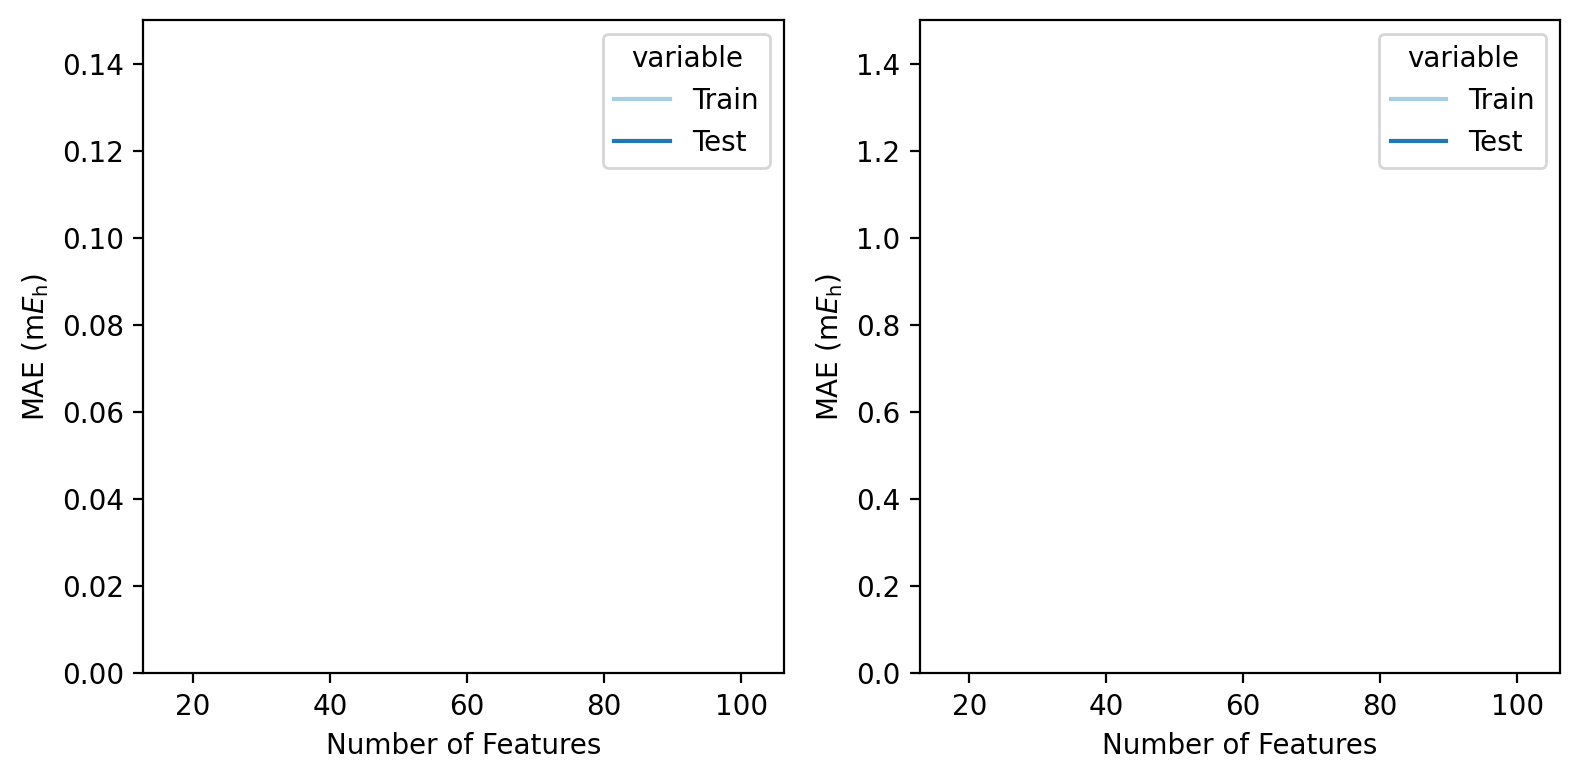

In [13]:
# pairedcp=sns.color_palette('Paired')
# fig, ax = plt.subplots(2,2,sharex=True)
# sns.lineplot(r2_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0][0],palette=pairedcp[0:2])
# sns.lineplot(r2_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[0][1],markers='x',palette=pairedcp[0:2])
# ax[0][0].set_title(r'Pair-Energies ($\varepsilon_{qs}$)')
# ax[0][1].set_title(r'Correlation Energies ($E_{2}$)')
# ax[0][0].set_ylim(0,1.05)
# ax[0][1].set_ylim(0,1.05)
# ax[0][0].set_ylabel("R$^{2}$")
# ax[0][1].set_ylabel("R$^{2}$")
# sns.lineplot(mae_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0],palette=pairedcp[0:2])
# ax[0].set_ylim(0,0.5)
# sns.lineplot(mae_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[1],palette=pairedcp[0:2])
# ax[1].set_ylim(0,5)
# ax[0].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
# ax[1].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
# plt.tight_layout()
# plt.savefig('images/VDZP_shap_curves.png',dpi=300,bbox_inches='tight')

pairedcp=sns.color_palette('Paired')
fig, ax = plt.subplots(1,2,sharex=True,figsize=(8,4))
sns.lineplot(mae_pair_df,x='Number of Features',y='value', hue='variable',ax=ax[0],palette=pairedcp[0:2])
ax[0].set_ylim(0,0.15)
sns.lineplot(mae_corr_df,x='Number of Features',y='value', hue='variable',ax=ax[1],palette=pairedcp[0:2])
ax[1].set_ylim(0,1.5)
ax[0].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
ax[1].set_ylabel("MAE (m$E_{\mathrm{h}}$)")
plt.tight_layout()
plt.savefig('images/VDZP_shap_curves.png',dpi=300,bbox_inches='tight')